In [26]:
import warnings
warnings.filterwarnings('ignore')


In [27]:
import logging
import pkgutil
import tarfile
import json
from io import BytesIO, StringIO
from typing import Optional, Tuple, Union, Dict

import numpy as np
import pandas as pd
import requests
from requests import RequestException
from sklearn.preprocessing import LabelEncoder

from alibi.utils.data import Bunch

logger = logging.getLogger(__name__)

ADULT_URLS = ['https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                'https://storage.googleapis.com/seldon-datasets/adult/adult.data',
              'http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/adult.data']

# -----

import os
from copy import deepcopy
from typing import List, Tuple, Dict, Callable

import tensorflow as tf
import tensorflow.keras as keras

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from alibi.explainers import CounterfactualRLTabular, CounterfactualRL
from alibi.models.tensorflow import HeAE
from alibi.models.tensorflow import Actor, Critic
from alibi.explainers.cfrl_base import Callback
from alibi.explainers.backends.cfrl_tabular import get_he_preprocessor, get_statistics, \
    get_conditional_vector, apply_category_mapping


def fetch_adult(features_drop: Optional[list] = None, return_X_y: bool = False, url_id: int = 0) -> \
        Union[Bunch, Tuple[np.ndarray, np.ndarray]]:
    """
    Downloads and pre-processes 'adult' dataset.
    More info: http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/

    Parameters
    ----------
    features_drop
        List of features to be dropped from dataset, by default drops ``["fnlwgt", "Education-Num"]``.
    return_X_y
        If ``True``, return features `X` and labels `y` as `numpy` arrays. If ``False`` return a `Bunch` object.
    url_id
        Index specifying which URL to use for downloading.

    Returns
    -------
    Bunch
        Dataset, labels, a list of features and a dictionary containing a list with the potential categories
        for each categorical feature where the key refers to the feature column.
    (data, target)
        Tuple if ``return_X_y=True``
    """
    if features_drop is None:
        features_drop = ["fnlwgt", "Education-Num"]

    # download data
    dataset_url = ADULT_URLS[url_id]
    raw_features = ['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num', 'Marital Status',
                    'Occupation', 'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss',
                    'Hours per week', 'Country', 'Target']
    try:
        resp = requests.get(dataset_url)
        resp.raise_for_status()
    except RequestException:
        logger.exception("Could not connect, URL may be out of service")
        raise

    raw_data = pd.read_csv(StringIO(resp.text), names=raw_features, delimiter=', ', engine='python').fillna('?')

    # get labels, features and drop unnecessary features
    labels = (raw_data['Target'] == '>50K').astype(int).values
    features_drop += ['Target']
    data = raw_data.drop(features_drop, axis=1)
    features = list(data.columns)

    # map categorical features
    education_map = {
        '10th': 'Dropout', '11th': 'Dropout', '12th': 'Dropout', '1st-4th':
            'Dropout', '5th-6th': 'Dropout', '7th-8th': 'Dropout', '9th':
            'Dropout', 'Preschool': 'Dropout', 'HS-grad': 'High School grad',
        'Some-college': 'High School grad', 'Masters': 'Masters',
        'Prof-school': 'Prof-School', 'Assoc-acdm': 'Associates',
        'Assoc-voc': 'Associates'
    }
    occupation_map = {
        "Adm-clerical": "Admin", "Armed-Forces": "Military",
        "Craft-repair": "Blue-Collar", "Exec-managerial": "White-Collar",
        "Farming-fishing": "Blue-Collar", "Handlers-cleaners":
            "Blue-Collar", "Machine-op-inspct": "Blue-Collar", "Other-service":
            "Service", "Priv-house-serv": "Service", "Prof-specialty":
            "Professional", "Protective-serv": "Other", "Sales":
            "Sales", "Tech-support": "Other", "Transport-moving":
            "Blue-Collar"
    }
    country_map = {
        'Cambodia': 'SE-Asia', 'Canada': 'British-Commonwealth', 'China':
            'China', 'Columbia': 'South-America', 'Cuba': 'Other',
        'Dominican-Republic': 'Latin-America', 'Ecuador': 'South-America',
        'El-Salvador': 'South-America', 'England': 'British-Commonwealth',
        'France': 'Euro_1', 'Germany': 'Euro_1', 'Greece': 'Euro_2',
        'Guatemala': 'Latin-America', 'Haiti': 'Latin-America',
        'Holand-Netherlands': 'Euro_1', 'Honduras': 'Latin-America',
        'Hong': 'China', 'Hungary': 'Euro_2', 'India':
            'British-Commonwealth', 'Iran': 'Other', 'Ireland':
            'British-Commonwealth', 'Italy': 'Euro_1', 'Jamaica':
            'Latin-America', 'Japan': 'Other', 'Laos': 'SE-Asia', 'Mexico':
            'Latin-America', 'Nicaragua': 'Latin-America',
        'Outlying-US(Guam-USVI-etc)': 'Latin-America', 'Peru':
            'South-America', 'Philippines': 'SE-Asia', 'Poland': 'Euro_2',
        'Portugal': 'Euro_2', 'Puerto-Rico': 'Latin-America', 'Scotland':
            'British-Commonwealth', 'South': 'Euro_2', 'Taiwan': 'China',
        'Thailand': 'SE-Asia', 'Trinadad&Tobago': 'Latin-America',
        'United-States': 'United-States', 'Vietnam': 'SE-Asia'
    }
    married_map = {
        'Never-married': 'Never-Married', 'Married-AF-spouse': 'Married',
        'Married-civ-spouse': 'Married', 'Married-spouse-absent':
            'Separated', 'Separated': 'Separated', 'Divorced':
            'Separated', 'Widowed': 'Widowed'
    }
    mapping = {'Education': education_map, 'Occupation': occupation_map, 'Country': country_map,
               'Marital Status': married_map}

    data_copy = data.copy()
    for f, f_map in mapping.items():
        data_tmp = data_copy[f].values
        for key, value in f_map.items():
            data_tmp[data_tmp == key] = value
        data[f] = data_tmp

    # get categorical features and apply labelencoding
    categorical_features = [f for f in features if data[f].dtype == 'O']
    category_map = {}
    for f in categorical_features:
        le = LabelEncoder()
        data_tmp = le.fit_transform(data[f].values)
        data[f] = data_tmp
        category_map[features.index(f)] = list(le.classes_)
    print(category_map)

    # only return data values
    data = data.values
    target_names = ['<=50K', '>50K']

    if return_X_y:
        return data, labels

    return Bunch(data=data, target=labels, feature_names=features, target_names=target_names, category_map=category_map)


In [28]:
class ADULTEncoder(keras.Model):
    """
    ADULT encoder used in the Counterfactual with Reinforcement Learning experiments. The model consists of
    two fully connected layers with ReLU and tanh nonlinearities. The tanh nonlinearity clips the embedding in [-1, 1]
    as required in the DDPG algorithm (e.g., [act_low, act_high]). The layers' dimensions used in the paper are
    128 and 15, although those can vary as they were selected to generalize across many datasets.
    """

    def __init__(self, hidden_dim: int, latent_dim: int, **kwargs):
        """
        Constructor.

        Parameters
        ----------
        hidden_dim
            Hidden dimension.
        latent_dim
            Latent dimension.
        """
        super().__init__(**kwargs)
        self.fc1 = keras.layers.Dense(hidden_dim)
        self.fc2 = keras.layers.Dense(latent_dim)

    def call(self, x: tf.Tensor, **kwargs) -> tf.Tensor:
        """
        Forward pass.

        Parameters
        ----------
        x
            Input tensor.
        **kwargs
            Other arguments.

        Returns
        -------
        Encoding representation having each component in the interval [-1, 1].
        """
        x = tf.nn.relu(self.fc1(x))
        x = tf.nn.tanh(self.fc2(x))
        return x


class ADULTDecoder(keras.Model):
    """
    ADULT decoder used in the Counterfactual with Reinforcement Learning experiments. The model consists of
    of a fully connected layer with ReLU nonlinearity, and a multiheaded layer, one for each categorical feature and
    a single head for the rest of numerical features. The hidden dimension used in the paper is 128.
    """

    def __init__(self, hidden_dim: int, output_dims: List[int], **kwargs):
        """
        Constructor.

        Parameters
        ----------
        hidden_dim
            Hidden dimension.
        output_dim
            List of output dimensions.
        """
        super().__init__(**kwargs)

        self.fc1 = keras.layers.Dense(hidden_dim)
        self.fcs = [keras.layers.Dense(dim) for dim in output_dims]

    def call(self, x: tf.Tensor, **kwargs) -> List[tf.Tensor]:
        """
        Forward pass.

        Parameters
        ----------
        x
            Input tensor.
        **kwargs
            Other arguments. Not used.

        Returns
        -------
        List of reconstruction of the input tensor. First element corresponds to the reconstruction of all the \
        numerical features if they exist, and the rest of the elements correspond to each categorical feature.
        """
        x = tf.nn.relu(self.fc1(x))
        xs = [fc(x) for fc in self.fcs]
        return xs

In [29]:
# Fetch adult dataset
adult = fetch_adult()

# Separate columns in numerical and categorical.
categorical_names = [adult.feature_names[i] for i in adult.category_map.keys()]
categorical_ids = list(adult.category_map.keys())

numerical_names = [name for i, name in enumerate(adult.feature_names) if i not in adult.category_map.keys()]
numerical_ids = [i for i in range(len(adult.feature_names)) if i not in adult.category_map.keys()]

# Split data into train and test
X, Y = adult.data, adult.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=13)

# -----

# Define numerical standard scaler.
num_transf = StandardScaler()

# Define categorical one-hot encoder.
cat_transf = OneHotEncoder(
    categories=[range(len(x)) for x in adult.category_map.values()],
    handle_unknown="ignore"
)

# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_transf, categorical_ids),
        ("num", num_transf, numerical_ids),
    ],
    sparse_threshold=0
)
# Fit preprocessor.
preprocessor.fit(X_train)

# Preprocess train and test dataset.
X_train_ohe = preprocessor.transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

# -----


# Select one of the below classifiers.
clf = XGBClassifier(min_child_weight=0.5, max_depth=3, gamma=0.2,random_state=1)
# clf = LogisticRegression(C=10)
# clf = DecisionTreeClassifier(max_depth=10, min_samples_split=5)
#clf = RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=50)

# Fit the classifier.
clf.fit(X_train_ohe, Y_train)

# -----

# Define prediction function.
predictor = lambda x: clf.predict_proba(preprocessor.transform(x))

from sklearn.metrics import classification_report

abc = classification_report(y_true=Y_test, y_pred=predictor(X_test).argmax(axis=1))

print(abc)

{1: ['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 2: ['Associates', 'Bachelors', 'Doctorate', 'Dropout', 'High School grad', 'Masters', 'Prof-School'], 3: ['Married', 'Never-Married', 'Separated', 'Widowed'], 4: ['?', 'Admin', 'Blue-Collar', 'Military', 'Other', 'Professional', 'Sales', 'Service', 'White-Collar'], 5: ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 6: ['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White'], 7: ['Female', 'Male'], 11: ['?', 'British-Commonwealth', 'China', 'Euro_1', 'Euro_2', 'Latin-America', 'Other', 'SE-Asia', 'South-America', 'United-States', 'Yugoslavia']}
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4959
           1       0.77      0.64      0.70      1554

    accuracy                           0.87      6513
   macro avg       0.83      0.79      0.81      6513

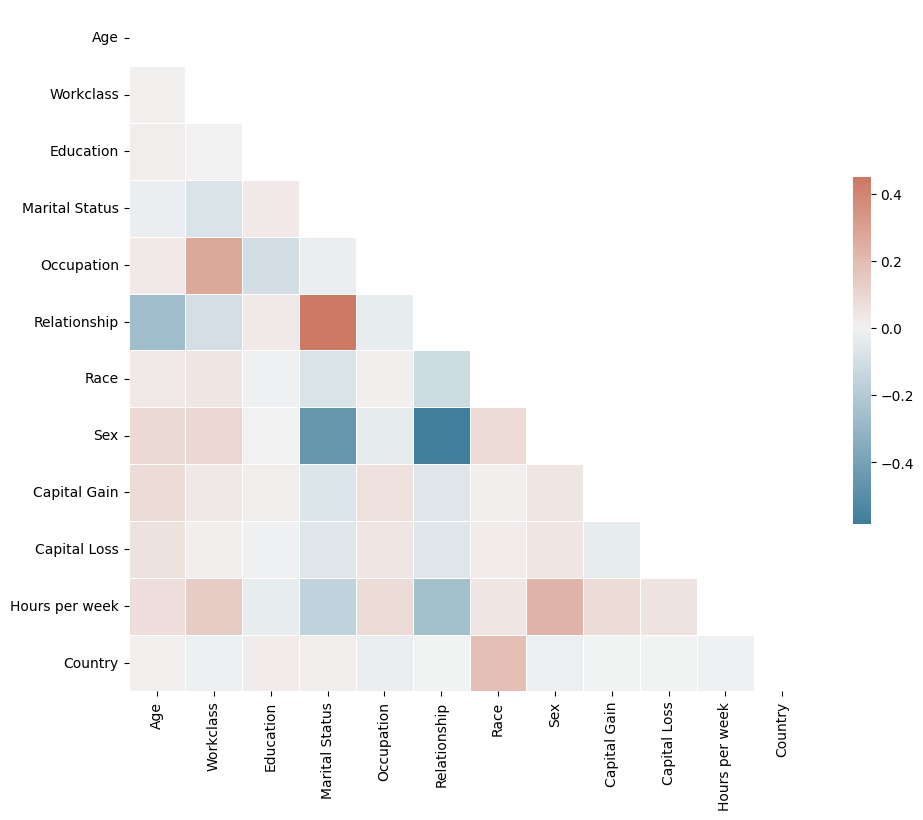

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X is a numpy array, convert it to a DataFrame
df2 = pd.DataFrame(X,columns=adult.feature_names)

# Compute the correlation matrix
corr = df2.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


# SHAP

In [31]:
import numpy as np

predictions = clf.predict(X_test_ohe)
predicted_as_0_indices = np.where(predictions == 0)[0]

# Extracting rows from X_test where the prediction by loaded_model is 1
rows_predicted_as_0 = X_test_ohe[predictions == 0]

# Saving the extracted rows to a .npy file
file_path = "predicted_as_1_adult.npy"
np.save(file_path, rows_predicted_as_0)



X_centered = X_test_ohe - X_test_ohe.mean()
distance = np.linalg.norm(X_centered, axis=1)

import pickle

model_path = "xgboost_model_adult.pkl"
pickle.dump(clf, open(model_path, 'wb'))

with open('xgboost_model_adult.pkl', 'rb') as file:
    loaded_model = pickle.load(file)




In [32]:
import shap
explainer = shap.Explainer(loaded_model)

In [33]:
distances_predicted_as_0 = distance[predicted_as_0_indices]
outlier_indices_predicted_as_0 = distances_predicted_as_0.argsort()[-5:]
final_outlier_indices = predicted_as_0_indices[outlier_indices_predicted_as_0]
outliers_predicted_as_0 = X_test_ohe[final_outlier_indices]
final_outlier_indices

array([6238, 3503, 2188, 4832, 5860])

In [34]:
import numpy as np

def top_outliers_using_MAD(data, n=5):
    # Calculate the median of the data
    median = np.median(data, axis=0)
    
    # Calculate the absolute deviation from the median for each point
    absolute_deviation = np.abs(data - median)
    
    # Calculate the median of these absolute deviations
    mad = np.median(absolute_deviation, axis=0)
    
    # Compute the modified Z-score
    # Note: The constant 1.4826 ensures consistency with the standard deviation for normally distributed data
    modified_z_score =  absolute_deviation / mad
    
    # Calculate the overall score as the sum of modified Z-scores across features
    overall_z_score = np.sum(modified_z_score, axis=1)
    
    # Get the indices of the top n outliers
    outliers_indices = overall_z_score.argsort()[-n:]
    
    return outliers_indices

# Assuming X_test_ohe is your data
outlier_indices = top_outliers_using_MAD(X_test_ohe, n=5)
print("Indices of top 5 outliers:", outlier_indices)


Indices of top 5 outliers: [2165 2164 2163 2173 6512]


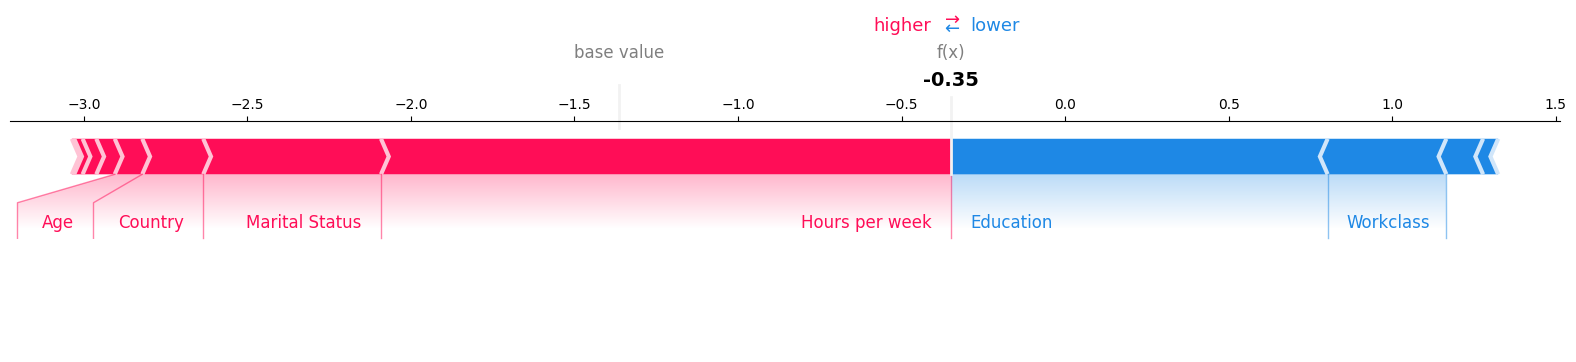

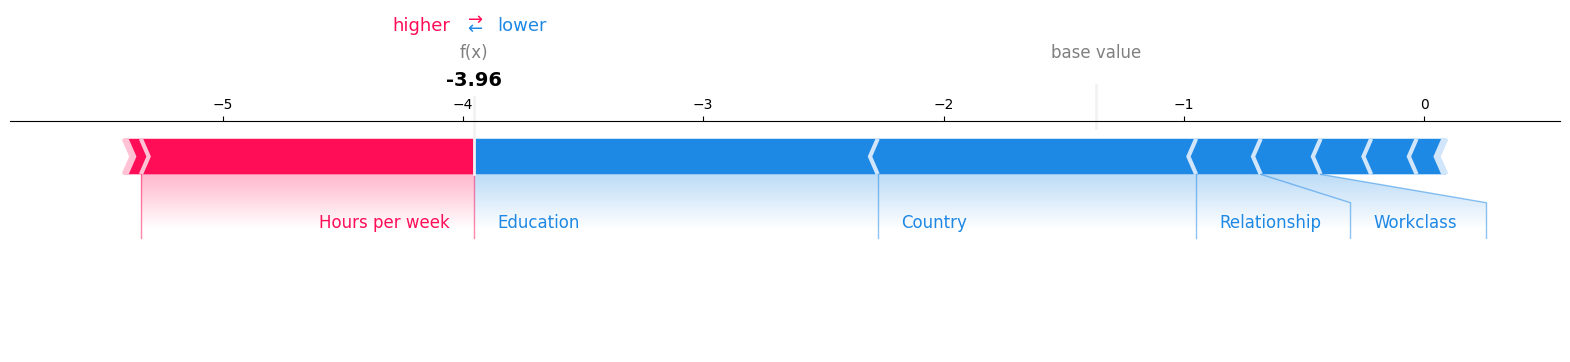

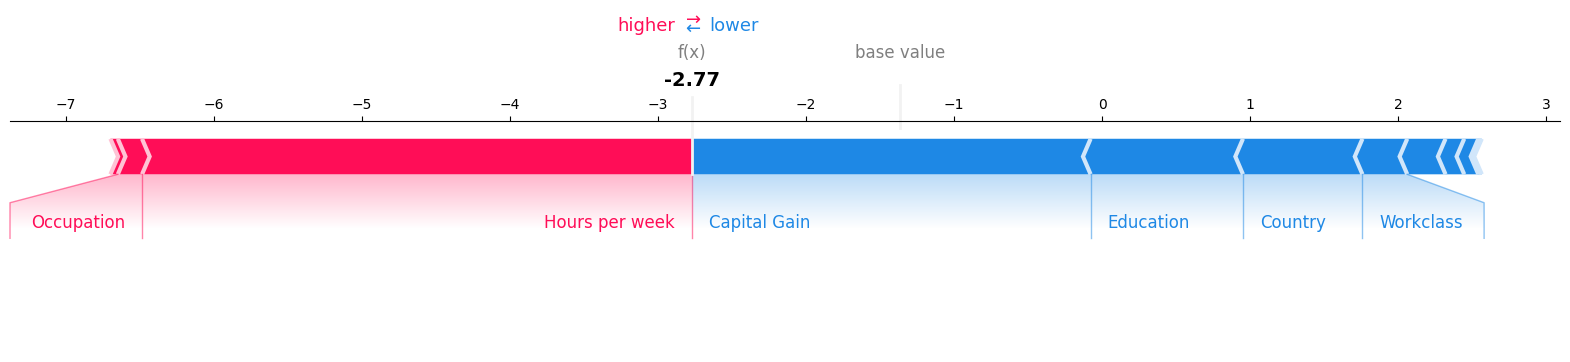

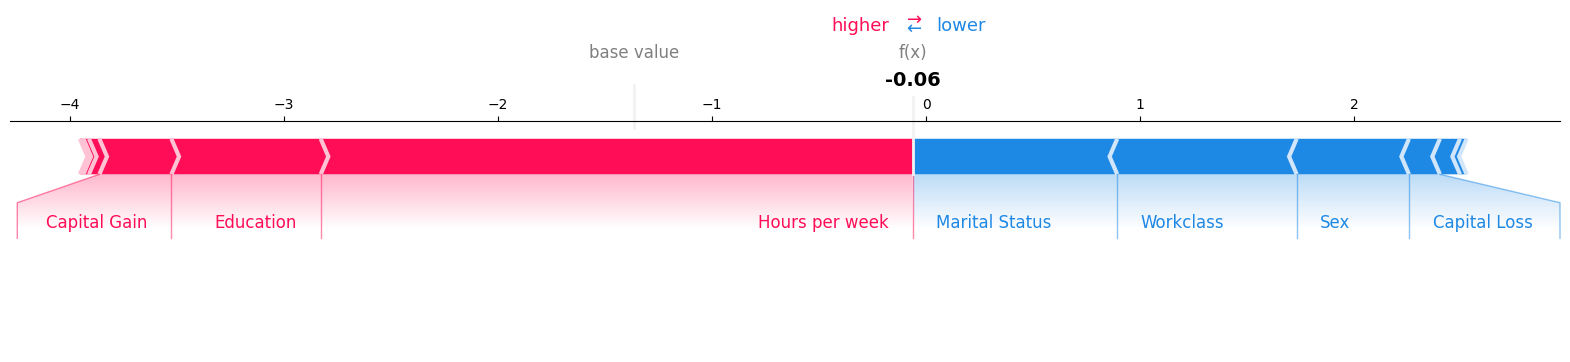

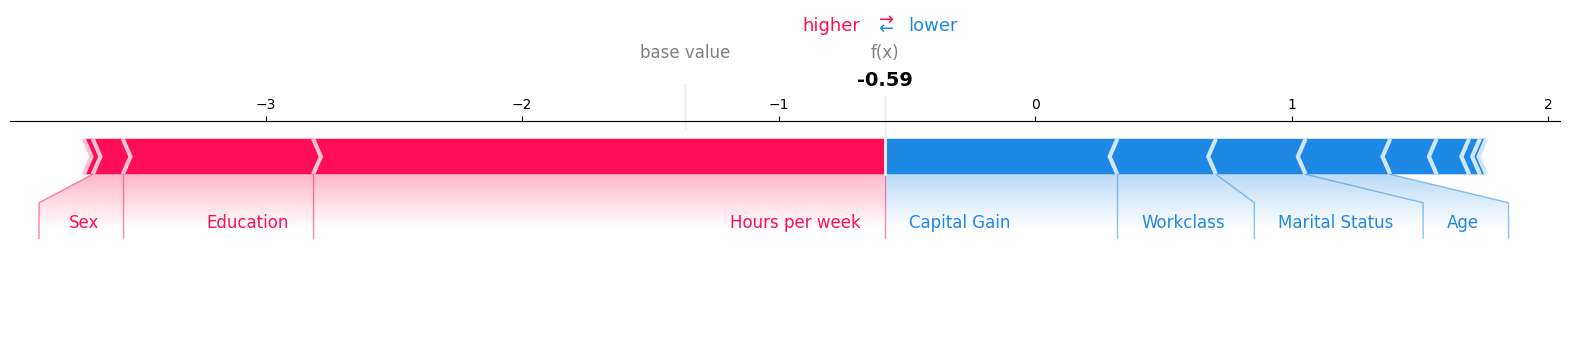

In [35]:
ohe_feature_names = preprocessor.named_transformers_["cat"].get_feature_names_out(input_features=categorical_names)


all_feature_names = list(ohe_feature_names) + numerical_names

def merge_shap_for_ohe(shap_values, categorical_names, ohe_feature_names):
    """
    Merge SHAP values for one-hot encoded features.
    """
    merged_shap_values = []
    start_idx = 0
    for cat_name in categorical_names:
        # Find the number of columns this categorical feature has been expanded into
        ohe_cols = [name for name in ohe_feature_names if cat_name in name]
        num_ohe_cols = len(ohe_cols)
        
        # Sum the SHAP values for these columns
        summed_shap = np.sum(shap_values[:, start_idx:start_idx+num_ohe_cols], axis=1)
        merged_shap_values.append(summed_shap)
        
        start_idx += num_ohe_cols
    
    # Add SHAP values for numerical features
    for i in range(start_idx, shap_values.shape[1]):
        merged_shap_values.append(shap_values[:, i])
    
    return np.column_stack(merged_shap_values)

shap_values_outliers = explainer.shap_values(outliers_predicted_as_0)

merged_shap_values_outliers = merge_shap_for_ohe(shap_values_outliers, categorical_names, ohe_feature_names)


for i in range(outliers_predicted_as_0.shape[0]):
    shap.force_plot(
        explainer.expected_value, 
        merged_shap_values_outliers[i], 
        feature_names=adult.feature_names,
        matplotlib=True
    )




In [36]:
centered_indices_predicted_as_0 = distances_predicted_as_0.argsort()[:5]
final_centered_indices = predicted_as_0_indices[centered_indices_predicted_as_0]
centered_values_predicted_as_0 = X_test_ohe[final_centered_indices]
final_centered_indices

array([ 766, 2893, 1183, 2118, 1348])

In [37]:
import numpy as np

def top_centres_using_MAD(data, n):
    # Calculate the median of the data
    median = np.median(data, axis=0)
    
    # Calculate the absolute deviation from the median for each point
    absolute_deviation = np.abs(data - median)
    
    # Calculate the median of these absolute deviations
    mad = np.median(absolute_deviation, axis=0)
    
    # Compute the modified Z-score
    # Note: The constant 1.4826 ensures consistency with the standard deviation for normally distributed data
    modified_z_score =  absolute_deviation / mad
    
    # Calculate the overall score as the sum of modified Z-scores across features
    overall_z_score = np.sum(modified_z_score, axis=1)
    
    # Get the indices of the top n outliers
    outliers_indices = overall_z_score.argsort()[:n]
    
    return outliers_indices

# Assuming X_test_ohe is your data
centre_indices = top_centres_using_MAD(X_test_ohe, n=5)
print("Indices of top 5 centres:", centre_indices)


Indices of top 5 centres: [   0 4347 4346 4345 4344]


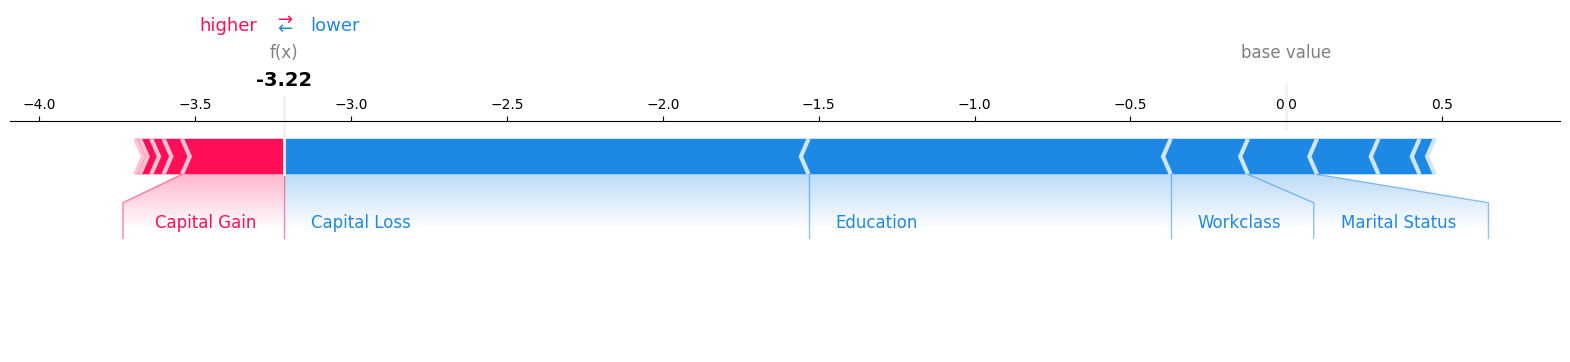

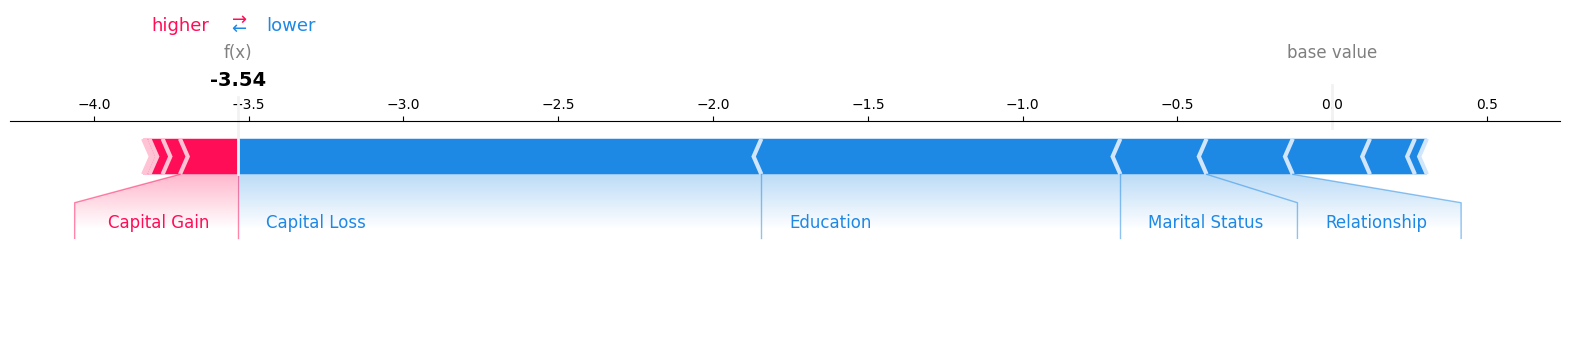

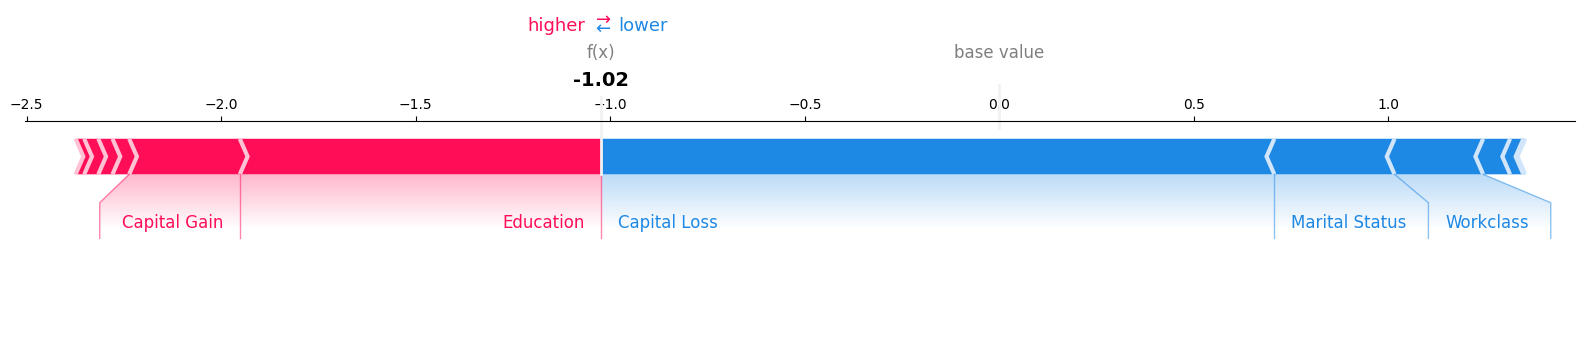

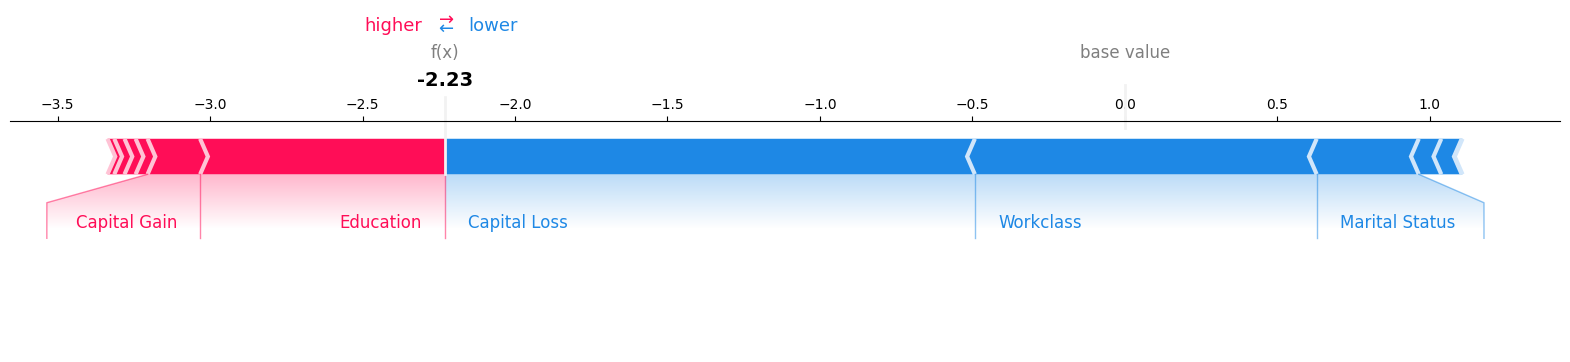

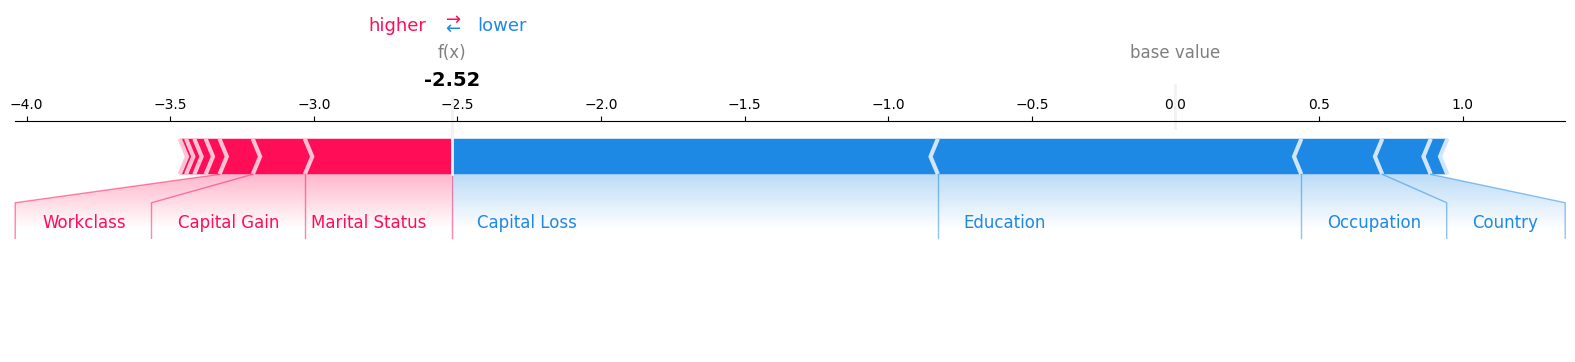

In [38]:

shap_values_centres = shap.Explainer(loaded_model).shap_values(centered_values_predicted_as_0)

merged_shap_values_centres = merge_shap_for_ohe(shap_values_centres, categorical_names, ohe_feature_names)

for i in range(outliers_predicted_as_0.shape[0]):
    shap.force_plot(
        shap.Explainer(loaded_model).expected_value, 
        merged_shap_values_centres[i], 
        feature_names=adult.feature_names,
        matplotlib=True
    )




# Metrics

In [39]:
from sklearn.neighbors import NearestNeighbors

def find_proximity_cont(cfe, original_datapoint, continuous_features, mads):
    diff = original_datapoint[continuous_features].to_numpy() - cfe[continuous_features].to_numpy()
    dist_cont = np.mean(np.divide(np.abs(diff), mads))
    sparsity_cont = diff[0].nonzero()[0].shape[0]
    return dist_cont, sparsity_cont

def find_proximity_cat(cfe, original_datapoint, encoded_columns):
    """
    cfe: Counterfactual example after one-hot encoding.
    original_datapoint: Original data point after one-hot encoding.
    encoded_columns: List of columns after one-hot encoding.
    """
    sparsity_cat = 0
    total_features = len(encoded_columns)

    diff = original_datapoint[encoded_columns].to_numpy() - cfe[encoded_columns].to_numpy()
  
    sparsity_cat = np.sum(np.any(diff != 0, axis=0))

    dist_cat = sparsity_cat * 1.0 / total_features
    return dist_cat, sparsity_cat

def get_encoded_columns(original_column, cfe_columns):
    """Get the OneHotEncoded column names for a given original column."""
    return [col for col in cfe_columns if col.startswith(original_column + "_")]

def follows_causality(cfe, original_datapoint, immutable_features, 
        non_decreasing_features, correlated_features):
    follows = True
    diff = cfe.to_numpy().astype(float) - original_datapoint.to_numpy()
    m2 = (diff != 0)[0].nonzero()
    changed_columns = cfe.columns[m2].tolist()
    
    # Convert immutable features to their encoded names
    immutable_features_encoded = []
    for feature in immutable_features:
        immutable_features_encoded.extend(get_encoded_columns(feature, cfe.columns))
    
    # Check immutable features
    changed_immutable_features = set(changed_columns).intersection(set(immutable_features_encoded))
    if changed_immutable_features:
# #         print("Warning: The following immutable features were changed:", changed_immutable_features)
#         if not any(x in method for x in ["dice-vae", "MACE", "CFproto"]):
            follows = False
            return follows

    # Convert non-decreasing features to their encoded names
    non_decreasing_features_encoded = []
    for feature in non_decreasing_features:
        non_decreasing_features_encoded.extend(get_encoded_columns(feature, cfe.columns))
    
    # Check non-decreasing features
    diff_nondecrease = cfe[non_decreasing_features_encoded].to_numpy().astype(float) - original_datapoint[non_decreasing_features_encoded].to_numpy()
    m2 = (diff_nondecrease < 0)[0].nonzero()
    if m2[0].shape[0] > 0:
        follows = False
        return follows
    
    # Check correlated features
    for f1, f2 in correlated_features:
        f1_encoded = get_encoded_columns(f1, cfe.columns)
        f2_encoded = get_encoded_columns(f2, cfe.columns)
        for col1 in f1_encoded:
            seq_f1 = cfe.columns.tolist().index(col1)
            for col2 in f2_encoded:
                seq_f2 = cfe.columns.tolist().index(col2)
                if (diff[0][seq_f1] > 0 and diff[0][seq_f2] <= 0) or (diff[0][seq_f1] < 0 and diff[0][seq_f2] >= 0):
                    follows = False
                    return follows
 

    return follows




def find_manifold_dist(cfe, knn):
    nearest_dist, nearest_points = knn.kneighbors(cfe.to_numpy(), 1, return_distance=True)
    quantity = np.mean(nearest_dist)		# Now we have that lambda, so no need to divide by self.no_points 
    return quantity

def calculate_metrics(counterfactuals_list, dataset, continuous_features, 
                      immutable_features, non_decreasing_features, 
                      correlated_features, scaler, method):
    
     # 获取OneHotEncoder的输出列名
    encoder = scaler.named_transformers_['cat']
    categorical_features = dataset.columns[categorical_ids].tolist()
    encoded_columns = encoder.get_feature_names_out(input_features=categorical_features).tolist()
    
    # 组合连续特征和编码后的分类特征的列名
    all_transformed_columns = continuous_features + encoded_columns
    
    # 1. Transform the dataset
    transformed_dataset = scaler.transform(dataset.drop(columns=['Outcome']))
    transformed_dataset = pd.DataFrame(transformed_dataset, columns=all_transformed_columns)
    
    # 2. Calculate normalized MADS for continuous features
    normalized_mads = {}
    for feature in continuous_features:
        normalized_mads[feature] = np.median(abs(transformed_dataset[feature].values - np.median(transformed_dataset[feature].values)))
    mads = [normalized_mads[key] if normalized_mads[key] != 0.0 else 1.0 for key in normalized_mads]
    
    # 3. Setup KNN for manifold distance
    knn = NearestNeighbors(n_neighbors=5, p=1)
    knn.fit(transformed_dataset)
    
    # 4. Loop through counterfactuals to calculate metrics
    avg_proximity_cont = []
    avg_proximity_cat = []
    avg_sparsity = []
    avg_causality = []
    avg_manifold_dist = []
    
    
    for instance_series, cf_df in counterfactuals_list:
        instance_df = pd.DataFrame(instance_series)
    
        if method == 'cfrl':
            instance_df = instance_df.iloc[:, :-1]
            cf_df = cf_df.iloc[:, :-1]
    
        elif method == 'kdtree':
            instance_df = instance_df.T
    
        elif method in ['random', 'genetic']:
            instance_df = instance_df.T
            cf_df = cf_df.iloc[:, :-1]
        
        # Transform data
        cfe = cf_df 
        cfe_transformed = scaler.transform(cf_df)
        instance_df_transformed = scaler.transform(instance_df)
        cfe_transformed = pd.DataFrame(cfe_transformed, columns=all_transformed_columns)
        instance_df_transformed = pd.DataFrame(instance_df_transformed, columns=all_transformed_columns)

        

        # Proximity
        proximity_cont, sparsity_cont = find_proximity_cont(cfe_transformed, instance_df_transformed, continuous_features, mads)
        proximity_cat, sparsity_cat = find_proximity_cat(cfe_transformed, instance_df_transformed, encoded_columns)
        
        # Sparsity
        sparsity = sparsity_cont + sparsity_cat
        
        # Causality
        causality = follows_causality(cfe_transformed, instance_df_transformed, immutable_features, 
                                      non_decreasing_features, correlated_features)
        
        # Manifold Distance
        manifold_dist = find_manifold_dist(cfe_transformed, knn)
        
        avg_proximity_cont.append(proximity_cont)
        avg_proximity_cat.append(proximity_cat)
        avg_sparsity.append(sparsity)
        avg_causality.append(causality)
        avg_manifold_dist.append(manifold_dist)
    
    # 5. Calculate average metrics
    avg_metrics = {
        "avg_proximity_cont": np.mean(avg_proximity_cont),
        "avg_proximity_cat": np.mean(avg_proximity_cat),
        "avg_sparsity": np.mean(avg_sparsity),
        "avg_causality": np.mean(avg_causality),
        "avg_manifold_dist": np.mean(avg_manifold_dist)
    }
    
    return avg_metrics


# encoder

In [40]:
# Define attribute types, required for datatype conversion.
feature_types = {"Age": int, "Capital Gain": int, "Capital Loss": int, "Hours per week": int}

# Define data preprocessor and inverse preprocessor. The invers preprocessor include datatype conversions.
heae_preprocessor, heae_inv_preprocessor = get_he_preprocessor(X=X_train,
                                                               feature_names=adult.feature_names,
                                                               category_map=adult.category_map,
                                                               feature_types=feature_types)

# Define trainset
trainset_input = heae_preprocessor(X_train).astype(np.float32)
trainset_outputs = {
    "output_1": trainset_input[:, :len(numerical_ids)]
}

for i, cat_id in enumerate(categorical_ids):
    trainset_outputs.update({
        f"output_{i+2}": X_train[:, cat_id]
    })
    
trainset = tf.data.Dataset.from_tensor_slices((trainset_input, trainset_outputs))
trainset = trainset.shuffle(1024).batch(128, drop_remainder=True)

# -----

# Define autoencoder path and create dir if it doesn't exist.
heae_path = os.path.join("tensorflow", "ADULT_autoencoder")
if not os.path.exists(heae_path):
    os.makedirs(heae_path)

# Define constants.
EPOCHS = 50              # epochs to train the autoencoder
HIDDEN_DIM = 128         # hidden dimension of the autoencoder
LATENT_DIM = 15          # define latent dimension

# Define output dimensions.
OUTPUT_DIMS = [len(numerical_ids)]
OUTPUT_DIMS += [len(adult.category_map[cat_id]) for cat_id in categorical_ids]

# Define the heterogeneous auto-encoder.
heae = HeAE(encoder=ADULTEncoder(hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM),
            decoder=ADULTDecoder(hidden_dim=HIDDEN_DIM, output_dims=OUTPUT_DIMS))

# Define loss functions.
he_loss = [keras.losses.MeanSquaredError()]
he_loss_weights = [1.]

# Add categorical losses.
for i in range(len(categorical_names)):
    he_loss.append(keras.losses.SparseCategoricalCrossentropy(from_logits=True))
    he_loss_weights.append(1./len(categorical_names))

# Define metrics.
metrics = {}
for i, cat_name in enumerate(categorical_names):
    metrics.update({f"output_{i+2}": keras.metrics.SparseCategoricalAccuracy()})
    
# Compile model.
heae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
             loss=he_loss,
             loss_weights=he_loss_weights,
             metrics=metrics)

if len(os.listdir(heae_path)) == 0:
    # Fit and save autoencoder.
    heae.fit(trainset, epochs=EPOCHS)
    heae.save(heae_path, save_format="tf")
else:
    # Load the model.
    heae = keras.models.load_model(heae_path, compile=False)



# CF

In [41]:
# -----


# Define constants
COEFF_SPARSITY = 0.5               # sparisty coefficient
COEFF_CONSISTENCY = 0.5            # consisteny coefficientcorrelated_features
TRAIN_STEPS = 10000                # number of training steps -> consider increasing the number of steps
BATCH_SIZE = 100                   # batch size

# Define immutable features.
immutable_features = ['Marital Status', 'Relationship', 'Race', 'Sex']

# Define ranges. This means that the `Age` feature can not decrease.
ranges = {'Age': [0.0, 1.0]}

# -----

explainer = CounterfactualRLTabular(predictor=predictor,
                                    encoder=heae.encoder,
                                    decoder=heae.decoder,
                                    latent_dim=LATENT_DIM,
                                    encoder_preprocessor=heae_preprocessor,
                                    decoder_inv_preprocessor=heae_inv_preprocessor,
                                    coeff_sparsity=COEFF_SPARSITY,
                                    coeff_consistency=COEFF_CONSISTENCY,
                                    category_map=adult.category_map,
                                    feature_names=adult.feature_names,
                                    ranges=ranges,
                                    immutable_features=immutable_features,
                                    train_steps=TRAIN_STEPS,
                                    batch_size=BATCH_SIZE,
                                    backend="tensorflow")
# Fit the explainer.
explainer = explainer.fit(X=X_train)

  0%|          | 0/10000 [00:00<?, ?it/s]2023-08-31 05:36:58.408275: E tensorflow/stream_executor/cuda/cuda_blas.cc:232] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED
2023-08-31 05:36:58.408306: E tensorflow/stream_executor/cuda/cuda_blas.cc:234] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2023-08-31 05:36:58.408332: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at matmul_op_impl.h:442 : INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support
  0%|          | 0/10000 [00:00<?, ?it/s]


InternalError: Exception encountered when calling layer "adult_encoder" (type ADULTEncoder).

Graph execution error:

Detected at node 'dense/MatMul' defined at (most recent call last):
    File "/root/miniconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/root/miniconda3/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/root/miniconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/root/miniconda3/lib/python3.8/site-packages/traitlets/config/application.py", line 978, in launch_instance
      app.start()
    File "/root/miniconda3/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/root/miniconda3/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/root/miniconda3/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/root/miniconda3/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/root/miniconda3/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/root/miniconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/root/miniconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/root/miniconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/root/miniconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/root/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/root/miniconda3/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/root/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "/root/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/root/miniconda3/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/root/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/root/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/root/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_36618/3373472421.py", line 70, in <module>
      heae = keras.models.load_model(heae_path, compile=False)
    File "/root/miniconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/root/miniconda3/lib/python3.8/site-packages/keras/saving/save.py", line 207, in load_model
      return saved_model_load.load(filepath_str, compile, options)
    File "/root/miniconda3/lib/python3.8/site-packages/keras/saving/saved_model/load.py", line 141, in load
      loaded = tf.__internal__.saved_model.load_partial(
Node: 'dense/MatMul'
Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[{{node dense/MatMul}}]] [Op:__inference_restored_function_body_7215]

Call arguments received:
  • args=('tf.Tensor(shape=(100, 57), dtype=float32)',)
  • kwargs={'training': 'False'}

In [93]:
# Select some positive examples.
X_negative = X_test[np.argmax(predictor(X_test), axis=1) == 0]

Y_t = np.array([1]) # target array

C = [] # desired feature range



In [106]:
X = X_test[6238].reshape(1, -1)
explanation = explainer.explain(X=X, Y_t=Y_t, C=C, diversity=True, num_samples=100, batch_size=10)

counterfactuals_list_cfrl = []

# Concat labels to the original instances.
orig = np.concatenate(
    [explanation.data['orig']['X'], explanation.data['orig']['class']],
    axis=1
)

# Concat labels to the counterfactual instances.
cf = np.concatenate(
    [explanation.data['cf']['X'], explanation.data['cf']['class']],
    axis=1
)

# Define new feature names and category map by including the label.
feature_names = adult.feature_names + ["Label"]
category_map = deepcopy(adult.category_map)
category_map.update({feature_names.index("Label"): adult.target_names})

# Replace label encodings with strings.
orig_pd = pd.DataFrame(
    apply_category_mapping(orig, category_map),
    columns=feature_names
)

cf_pd = pd.DataFrame(
    apply_category_mapping(cf, category_map),
    columns=feature_names
)

counterfactuals_list_cfrl.append((orig_pd, cf_pd))

merged_df = pd.concat([orig_pd, cf_pd.head(5)])
print(merged_df)
merged_df.to_csv("a_cfrl_o.csv")

metrics_cfrl = calculate_metrics(counterfactuals_list_cfrl, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='cfrl')
print(metrics_cfrl)


12it [00:00, 53.42it/s]

  Age Workclass         Education Marital Status    Occupation   Relationship  \
0  36   Private  High School grad  Never-Married  White-Collar  Not-in-family   
0  37   Private  High School grad  Never-Married  White-Collar  Not-in-family   
1  37   Private  High School grad  Never-Married  White-Collar  Not-in-family   
2  37   Private  High School grad  Never-Married  White-Collar  Not-in-family   
3  38   Private  High School grad  Never-Married  White-Collar  Not-in-family   
4  38   Private  High School grad  Never-Married  White-Collar  Not-in-family   

    Race   Sex Capital Gain Capital Loss Hours per week        Country  Label  
0  White  Male            0         2258             70  United-States  <=50K  
0  White  Male         8736         2115             68  United-States   >50K  
1  White  Male         8888         2173             68  United-States   >50K  
2  White  Male         9046         2118             68  United-States   >50K  
3  White  Male         7302     

In [107]:
X = X_test[766].reshape(1, -1)
explanation = explainer.explain(X=X, Y_t=Y_t, C=C, diversity=True, num_samples=100, batch_size=10)

counterfactuals_list_cfrl = []

# Concat labels to the original instances.
orig = np.concatenate(
    [explanation.data['orig']['X'], explanation.data['orig']['class']],
    axis=1
)

# Concat labels to the counterfactual instances.
cf = np.concatenate(
    [explanation.data['cf']['X'], explanation.data['cf']['class']],
    axis=1
)

# Define new feature names and category map by including the label.
feature_names = adult.feature_names + ["Label"]
category_map = deepcopy(adult.category_map)
category_map.update({feature_names.index("Label"): adult.target_names})

# Replace label encodings with strings.
orig_pd = pd.DataFrame(
    apply_category_mapping(orig, category_map),
    columns=feature_names
)

cf_pd = pd.DataFrame(
    apply_category_mapping(cf, category_map),
    columns=feature_names
)

counterfactuals_list_cfrl.append((orig_pd, cf_pd))

merged_df = pd.concat([orig_pd, cf_pd.head(5)])
print(merged_df)
merged_df.to_csv("a_cfrl_c.csv")

metrics_cfrl = calculate_metrics(counterfactuals_list_cfrl, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='cfrl')
print(metrics_cfrl)

11it [00:00, 49.75it/s]

  Age Workclass         Education Marital Status   Occupation Relationship  \
0  41   Private  High School grad      Separated  Blue-Collar    Unmarried   
0  40   Private  High School grad      Separated  Blue-Collar    Unmarried   
1  40   Private  High School grad      Separated  Blue-Collar    Unmarried   
2  40   Private  High School grad      Separated  Blue-Collar    Unmarried   
3  40   Private  High School grad      Separated  Blue-Collar    Unmarried   
4  40   Private  High School grad      Separated  Blue-Collar    Unmarried   

    Race   Sex Capital Gain Capital Loss Hours per week        Country  Label  
0  White  Male         2174            0             40          Other  <=50K  
0  White  Male         8251            0             40  South-America   >50K  
1  White  Male         8306            0             40  United-States   >50K  
2  White  Male         8337            0             40  United-States   >50K  
3  White  Male         8381            0             

In [96]:
import time

X = X_negative[100:300]
Y_t = np.array([1])
C = []

counterfactuals_list_cfrl = []
time_list = []
validity_list = []

# Assuming X_positive, Y_t, C, category_map, feature_names are already defined
for i in range(X.shape[0]):
    X = X_negative[i].reshape(1, -1)
    
  
    start_time = time.time()
    
    explanation = explainer.explain(X=X, Y_t=Y_t, C=C, diversity=True, num_samples=5, batch_size=10)
    
    time_taken = time.time() - start_time
    time_list.append(time_taken)
    
    # Concat label column.
    orig = np.concatenate(
        [explanation.data['orig']['X'], explanation.data['orig']['class']],
        axis=1
    )

    cf = np.concatenate(
        [explanation.data['cf']['X'], explanation.data['cf']['class']],
        axis=1
    )
   
    # Define new feature names and category map by including the label.
    feature_names = adult.feature_names + ["Label"]
    category_map = deepcopy(adult.category_map)
    category_map.update({feature_names.index("Label"): adult.target_names})

    # Transform label encodings to string.
    orig_pd = pd.DataFrame(
        apply_category_mapping(orig, category_map),
        columns=feature_names,
    )

    cf_pd = pd.DataFrame(
        apply_category_mapping(cf, category_map),
        columns=feature_names,
    )
    
    # Check validity
    if orig_pd['Label'].iloc[0] != cf_pd['Label'].iloc[0]:
        validity_list.append(1)
    else:
        validity_list.append(0)
    
    counterfactuals_list_cfrl.append((orig_pd, cf_pd))

# Calculate average time and validity
avg_time_0_1 = np.mean(time_list)
avg_validity_0_1 = np.mean(validity_list)

print("Average Time Taken per instance:", avg_time_0_1)
print("Average Validity:", avg_validity_0_1)



1it [00:00, 36.38it/s]
1it [00:00, 55.85it/s]
1it [00:00, 48.80it/s]
1it [00:00, 56.06it/s]
1it [00:00, 55.85it/s]
1it [00:00, 55.87it/s]
1it [00:00, 55.24it/s]
1it [00:00, 55.32it/s]
1it [00:00, 55.65it/s]
1it [00:00, 56.36it/s]
1it [00:00, 55.67it/s]
1it [00:00, 55.89it/s]
1it [00:00, 55.46it/s]
1it [00:00, 56.05it/s]
1it [00:00, 55.60it/s]
1it [00:00, 55.47it/s]
1it [00:00, 41.35it/s]
1it [00:00, 54.40it/s]
1it [00:00, 54.92it/s]
1it [00:00, 54.65it/s]
1it [00:00, 54.36it/s]
1it [00:00, 54.91it/s]
1it [00:00, 53.73it/s]
1it [00:00, 54.04it/s]
1it [00:00, 55.07it/s]
1it [00:00, 55.33it/s]
1it [00:00, 55.21it/s]
1it [00:00, 54.25it/s]
1it [00:00, 53.83it/s]
1it [00:00, 55.85it/s]
1it [00:00, 55.04it/s]
1it [00:00, 55.43it/s]
1it [00:00, 54.01it/s]
1it [00:00, 55.67it/s]
1it [00:00, 54.87it/s]
1it [00:00, 54.27it/s]
1it [00:00, 54.05it/s]
1it [00:00, 54.49it/s]
1it [00:00, 54.56it/s]
1it [00:00, 49.19it/s]
1it [00:00, 54.48it/s]
1it [00:00, 53.40it/s]
1it [00:00, 48.93it/s]
1it [00:00,

Average Time Taken per instance: 0.025185176134109498
Average Validity: 1.0


In [97]:
# Combine data and target into a single dataframe
df = pd.DataFrame(adult.data, columns=adult.feature_names)
df['Outcome'] = adult.target

metrics_cfrl = calculate_metrics(counterfactuals_list_cfrl, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='cfrl')
print(metrics_cfrl)

{'avg_proximity_cont': 0.0, 'avg_proximity_cat': 0.05339622641509433, 'avg_sparsity': 2.83, 'avg_causality': 0.0, 'avg_manifold_dist': 8.314425749810752}


In [23]:
X_positive = X_test[np.argmax(predictor(X_test), axis=1) == 1]

In [89]:
import time

X = X_positive[100:300]
Y_t = np.array([0])
C = []

counterfactuals_list_cfrl = []
time_list = []
validity_list = []

# Assuming X_positive, Y_t, C, category_map, feature_names are already defined
for i in range(X.shape[0]):
    X = X_positive[i].reshape(1, -1)
 
    start_time = time.time()
    
    explanation = explainer.explain(X=X, Y_t=Y_t, C=C, diversity=True, num_samples=5, batch_size=10)
    
   
    time_taken = time.time() - start_time
    time_list.append(time_taken)
    
    # Concat label column.
    orig = np.concatenate(
        [explanation.data['orig']['X'], explanation.data['orig']['class']],
        axis=1
    )


    # Check if 'cf' data is empty and replace with 'orig' data if necessary
    cf_X = explanation.data['cf']['X'] if explanation.data['cf']['X'].size != 0 else explanation.data['orig']['X']
    cf_class = explanation.data['cf']['class'] if explanation.data['cf']['class'].size != 0 else explanation.data['orig']['class']

    # Ensure both cf_X and cf_class are 2D arrays
    if len(cf_X.shape) == 1:
        cf_X = cf_X[:, np.newaxis]
    if len(cf_class.shape) == 1:
        cf_class = cf_class[:, np.newaxis]

# Concatenate the data
    cf = np.concatenate([cf_X, cf_class], axis=1)




    # cf = np.concatenate(
    #     [explanation.data['cf']['X'], explanation.data['cf']['class']],
    #     axis=1
    # )
   
    # Define new feature names and category map by including the label.
    feature_names = adult.feature_names + ["Label"]
    category_map = deepcopy(adult.category_map)
    category_map.update({feature_names.index("Label"): adult.target_names})

    # Transform label encodings to string.
    orig_pd = pd.DataFrame(
        apply_category_mapping(orig, category_map),
        columns=feature_names,
    )

    cf_pd = pd.DataFrame(
        apply_category_mapping(cf, category_map),
        columns=feature_names,
    )
    
    # Check validity
    if orig_pd['Label'].iloc[0] != cf_pd['Label'].iloc[0]:
        validity_list.append(1)
    else:
        validity_list.append(0)
    
    counterfactuals_list_cfrl.append((orig_pd, cf_pd))

# Calculate average time and validity
avg_time_1_0 = np.mean(time_list)
avg_validity_1_0 = np.mean(validity_list)

print("Average Time Taken per instance:", avg_time_1_0)
print("Average Validity:", avg_validity_1_0)



1it [00:00, 36.81it/s]
1it [00:00, 55.31it/s]
1it [00:00, 55.69it/s]
1it [00:00, 55.17it/s]
1it [00:00, 55.95it/s]
1it [00:00, 47.03it/s]
1it [00:00, 54.38it/s]
1it [00:00, 54.37it/s]
1it [00:00, 54.59it/s]
1it [00:00, 53.83it/s]
1it [00:00, 41.04it/s]
1it [00:00, 50.31it/s]
1it [00:00, 54.53it/s]
2it [00:00, 56.38it/s]
1it [00:00, 55.25it/s]
1it [00:00, 51.70it/s]
1it [00:00, 54.48it/s]
1it [00:00, 55.22it/s]
1it [00:00, 54.87it/s]
1it [00:00, 55.86it/s]
1it [00:00, 55.41it/s]
1it [00:00, 46.13it/s]
1it [00:00, 54.79it/s]
1it [00:00, 56.25it/s]
1it [00:00, 56.12it/s]
1it [00:00, 55.60it/s]
1it [00:00, 56.00it/s]
1it [00:00, 55.00it/s]
1it [00:00, 56.02it/s]
1it [00:00, 56.05it/s]
1it [00:00, 39.13it/s]
1it [00:00, 54.60it/s]
1it [00:00, 53.66it/s]
1000it [00:17, 57.62it/s]
1it [00:00, 55.18it/s]
1it [00:00, 57.63it/s]
1it [00:00, 51.17it/s]
1it [00:00, 55.36it/s]
1it [00:00, 55.83it/s]
1it [00:00, 54.94it/s]
1it [00:00, 55.10it/s]
1it [00:00, 55.32it/s]
1it [00:00, 54.81it/s]
1it [00:

Average Time Taken per instance: 0.6356397449970246
Average Validity: 0.965


In [90]:
continuous_features = ['Age', 'Capital Gain', 'Capital Loss', 'Hours per week']
immutable_features = ['Marital Status', 'Race', 'Country', 'Sex']
non_decreasing_features = ['Age', 'Education']
correlated_features = [('Education', 'Age')]

In [91]:
# Combine data and target into a single dataframe
df = pd.DataFrame(adult.data, columns=adult.feature_names)
df['Outcome'] = adult.target

metrics_cfrl = calculate_metrics(counterfactuals_list_cfrl, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='cfrl')
print(metrics_cfrl)

{'avg_proximity_cont': 0.0, 'avg_proximity_cat': 0.05896226415094339, 'avg_sparsity': 3.125, 'avg_causality': 0.035, 'avg_manifold_dist': 8.184396551052824}


# DiCE random


In [54]:
category_map = {
     1: ['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 
     2: ['Associates', 'Bachelors', 'Doctorate', 'Dropout', 'High School grad', 'Masters', 'Prof-School'], 
     3: ['Married', 'Never-Married', 'Separated', 'Widowed'], 
     4: ['?', 'Admin', 'Blue-Collar', 'Military', 'Other', 'Professional', 'Sales', 'Service', 'White-Collar'], 
     5: ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 
     6: ['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White'], 
     7: ['Female', 'Male'], 
     11: ['?', 'British-Commonwealth', 'China', 'Euro_1', 'Euro_2', 'Latin-America', 'Other', 'SE-Asia', 'South-America', 'United-States', 'Yugoslavia']
    }

In [100]:
import dice_ml

# Combine data and target into a single dataframe
df = pd.DataFrame(adult.data, columns=adult.feature_names)
df['Outcome'] = adult.target

# Define DiCE data object
d = dice_ml.Data(dataframe=df, 
                 continuous_features=numerical_names, 
                 outcome_name="Outcome")

# Define DiCE model object
backend = "sklearn"

class ModelWrapper:
    def __init__(self, predictor_func):
        self.predictor_func = predictor_func
    
    def predict_proba(self, instances):
        return self.predictor_func(instances)
    
    def predict(self, instances):
       
        prob_preds = self.predictor_func(instances)
    
        return np.argmax(prob_preds, axis=1)

model_wrapper = ModelWrapper(predictor)


m = dice_ml.Model(model=model_wrapper, backend=backend)


In [108]:
method = 'random'

counterfactuals_list = []


exp = dice_ml.Dice(d, m, method=method)
query_instance_df = pd.DataFrame([X_test[6238]], columns=adult.feature_names) #X_positive[0]
dice_exp = exp.generate_counterfactuals(query_instance_df, total_CFs=5, desired_class="opposite")


# dice_exp.visualize_as_dataframe()

final_cfs_df = dice_exp.cf_examples_list[0].final_cfs_df


merged_df = pd.concat([query_instance_df, final_cfs_df])

for col_index, categories in category_map.items():
    col_name = merged_df.columns[col_index]
    merged_df[col_name] = merged_df[col_name].apply(lambda x: categories[int(x)] if not pd.isna(x) else x)

print(merged_df)

merged_df.to_csv("a_random_o.csv")

counterfactuals_list.append((query_instance_df.T, final_cfs_df))

metrics_random = calculate_metrics(counterfactuals_list, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='random')
print(metrics_random)


100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


   Age Workclass         Education Marital Status    Occupation  \
0   36   Private  High School grad  Never-Married  White-Collar   
0   90   Private        Associates  Never-Married  White-Collar   
1   36   Private  High School grad  Never-Married  White-Collar   
2   36   Private  High School grad  Never-Married  White-Collar   
3   36   Private  High School grad  Never-Married  White-Collar   
4   59   Private  High School grad  Never-Married  White-Collar   

    Relationship   Race   Sex  Capital Gain  Capital Loss  Hours per week  \
0  Not-in-family  White  Male             0          2258              70   
0  Not-in-family  White  Male             0          2258              70   
1  Not-in-family  White  Male         83691          1124              70   
2  Not-in-family  White  Male             0          2258              78   
3  Not-in-family  White  Male             0          3007              70   
4  Not-in-family  White  Male             0          4110           

In [109]:
method = 'random'


exp = dice_ml.Dice(d, m, method=method)
query_instance_df = pd.DataFrame([X_test[766]], columns=adult.feature_names) #X_positive[0]
dice_exp = exp.generate_counterfactuals(query_instance_df, total_CFs=5, desired_class="opposite")


# dice_exp.visualize_as_dataframe()

final_cfs_df = dice_exp.cf_examples_list[0].final_cfs_df


merged_df = pd.concat([query_instance_df, final_cfs_df])

for col_index, categories in category_map.items():
    col_name = merged_df.columns[col_index]
    merged_df[col_name] = merged_df[col_name].apply(lambda x: categories[int(x)] if not pd.isna(x) else x)

print(merged_df)

merged_df.to_csv("a_random_c.csv")

counterfactuals_list = []

counterfactuals_list.append((query_instance_df.T, final_cfs_df))

metrics_random = calculate_metrics(counterfactuals_list, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='random')
print(metrics_random)

100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


   Age         Workclass         Education Marital Status   Occupation  \
0   41           Private  High School grad      Separated  Blue-Collar   
0   55           Private  High School grad      Separated  Blue-Collar   
1   41  Self-emp-not-inc  High School grad      Separated  Blue-Collar   
2   41           Private  High School grad      Separated  Blue-Collar   
3   41           Private  High School grad      Separated  Blue-Collar   
4   41           Private  High School grad      Separated  Blue-Collar   

  Relationship   Race   Sex  Capital Gain  Capital Loss  Hours per week  \
0    Unmarried  White  Male          2174             0              40   
0    Unmarried  White  Male         21915             0              40   
1    Unmarried  White  Male          8038             0              40   
2    Unmarried  White  Male         31636             0              40   
3    Unmarried  White  Male         13402             0              40   
4    Unmarried  White  Male    

In [77]:
counterfactuals_list = []

query_instance_df = pd.DataFrame(X_negative[100:300], columns=adult.feature_names)

time_list = []
validity_list = []


for _, instance in query_instance_df.iterrows():
    instance_df = pd.DataFrame(instance).T
    
    
    start_time = time.time()
    
    dice_exp = exp.generate_counterfactuals(instance_df, total_CFs=5, desired_class="opposite")
    
    
    time_taken = time.time() - start_time
    time_list.append(time_taken)
    
    # cf_df = dice_exp.visualize_as_dataframe(show_only_changes=False)
    if hasattr(dice_exp, 'cf_examples_list') and dice_exp.cf_examples_list:
        cf_df = dice_exp.cf_examples_list[0].final_cfs_df
        if cf_df is not None:
            counterfactuals_list.append((instance, cf_df))
            validity_list.append(1)
        else:
            counterfactuals_list.append((instance, None))
            validity_list.append(0)
    else:
        counterfactuals_list.append((instance, None))
        validity_list.append(0)
avg_time = np.mean(time_list)
avg_validity = np.mean(validity_list)

print("Average Time Taken per instance:", avg_time)
print("Average Validity:", avg_validity)  


100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

Average Time Taken per instance: 0.16072850108146666
Average Validity: 1.0


In [87]:
metrics_random = calculate_metrics(counterfactuals_list, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='random')
print(metrics_random)

{'avg_proximity_cont': 0.004750000000000001, 'avg_proximity_cat': 0.1009433962264151, 'avg_sparsity': 5.355, 'avg_causality': 0.01, 'avg_manifold_dist': 1.933111265484535}


# DiCE genetic

In [111]:
method = 'genetic'


exp = dice_ml.Dice(d, m, method=method)
query_instance_df = pd.DataFrame([X_test[6238]], columns=adult.feature_names) #X_positive[0]
dice_exp = exp.generate_counterfactuals(query_instance_df, total_CFs=5, desired_class="opposite")


# dice_exp.visualize_as_dataframe()

final_cfs_df = dice_exp.cf_examples_list[0].final_cfs_df


merged_df = pd.concat([query_instance_df, final_cfs_df])

for col_index, categories in category_map.items():
    col_name = merged_df.columns[col_index]
    merged_df[col_name] = merged_df[col_name].apply(lambda x: categories[int(x)] if not pd.isna(x) else x)

print(merged_df)

merged_df.to_csv("a_gene_o.csv")

counterfactuals_list = []

counterfactuals_list.append((query_instance_df.T, final_cfs_df))

metrics_genetic = calculate_metrics(counterfactuals_list, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='genetic')
print(metrics_genetic)

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

    Age Workclass         Education Marital Status    Occupation  \
0  36.0   Private  High School grad  Never-Married  White-Collar   
0  26.0   Private         Bachelors  Never-Married  White-Collar   
0  26.0   Private         Bachelors  Never-Married  White-Collar   
0  26.0   Private  High School grad  Never-Married         Other   
0  33.0   Private  High School grad      Separated   Blue-Collar   
0  27.0   Private  High School grad  Never-Married   Blue-Collar   

    Relationship   Race   Sex  Capital Gain  Capital Loss  Hours per week  \
0  Not-in-family  White  Male           0.0        2258.0            70.0   
0  Not-in-family  White  Male           0.0        2258.0            50.0   
0  Not-in-family  White  Male           0.0        2258.0            45.0   
0  Not-in-family  White  Male           0.0        2258.0             1.0   
0  Not-in-family  White  Male           0.0        2258.0            84.0   
0      Unmarried  White  Male           0.0        2258.0    

In [112]:
method = 'genetic'


exp = dice_ml.Dice(d, m, method=method)
query_instance_df = pd.DataFrame([X_test[766]], columns=adult.feature_names) #X_positive[0]
dice_exp = exp.generate_counterfactuals(query_instance_df, total_CFs=5, desired_class="opposite")


# dice_exp.visualize_as_dataframe()
final_cfs_df = dice_exp.cf_examples_list[0].final_cfs_df


merged_df = pd.concat([query_instance_df, final_cfs_df])

for col_index, categories in category_map.items():
    col_name = merged_df.columns[col_index]
    merged_df[col_name] = merged_df[col_name].apply(lambda x: categories[int(x)] if not pd.isna(x) else x)

print(merged_df)

merged_df.to_csv("a_hene_c.csv")

counterfactuals_list = []

counterfactuals_list.append((query_instance_df.T, final_cfs_df))

metrics_genetic = calculate_metrics(counterfactuals_list, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='genetic')
print(metrics_genetic)

100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

    Age Workclass         Education Marital Status   Occupation Relationship  \
0  41.0   Private  High School grad      Separated  Blue-Collar    Unmarried   
0  42.0   Private  High School grad        Married  Blue-Collar      Husband   
0  37.0   Private  High School grad        Married  Blue-Collar      Husband   
0  49.0   Private  High School grad        Married  Blue-Collar      Husband   
0  48.0   Private  High School grad        Married  Blue-Collar      Husband   
0  56.0   Private  High School grad        Married  Blue-Collar      Husband   

    Race   Sex  Capital Gain  Capital Loss  Hours per week        Country  \
0  White  Male        2174.0           0.0            40.0          Other   
0  White  Male        3103.0           0.0            45.0  United-States   
0  White  Male        3103.0           0.0            45.0  United-States   
0  White  Male        3103.0           0.0            45.0  United-States   
0  White  Male        3103.0           0.0            

In [74]:
counterfactuals_list = []

query_instance_df = pd.DataFrame(X_positive[100:300], columns=adult.feature_names)

time_list = []
validity_list = []


for _, instance in query_instance_df.iterrows():
    instance_df = pd.DataFrame(instance).T
    
    
    start_time = time.time()
    
    dice_exp = exp.generate_counterfactuals(instance_df, total_CFs=5, desired_class="opposite")
    
    
    time_taken = time.time() - start_time
    time_list.append(time_taken)
    
    # cf_df = dice_exp.visualize_as_dataframe(show_only_changes=False)
    if hasattr(dice_exp, 'cf_examples_list') and dice_exp.cf_examples_list:
        cf_df = dice_exp.cf_examples_list[0].final_cfs_df
        if cf_df is not None:
            counterfactuals_list.append((instance, cf_df))
            validity_list.append(1)
        else:
            counterfactuals_list.append((instance, None))
            validity_list.append(0)
    else:
        counterfactuals_list.append((instance, None))
        validity_list.append(0)
avg_time = np.mean(time_list)
avg_validity = np.mean(validity_list)

print("Average Time Taken per instance:", avg_time)
print("Average Validity:", avg_validity)  


100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

Average Time Taken per instance: 0.6821180295944214
Average Validity: 1.0


In [75]:
metrics_genetic = calculate_metrics(counterfactuals_list, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='genetic')
print(metrics_genetic)

{'avg_proximity_cont': 0.04875, 'avg_proximity_cat': 0.19943396226415092, 'avg_sparsity': 10.765, 'avg_causality': 0.0, 'avg_manifold_dist': 8.031214374777301}


# kdtree

In [61]:
method = 'kdtree'

# 用之前的代码生成反事实
exp = dice_ml.Dice(d, m, method=method)
query_instance_df = pd.DataFrame([X_test[6238]], columns=adult.feature_names) #X_positive[0]
dice_exp = exp.generate_counterfactuals(query_instance_df, total_CFs=5, desired_class="opposite")

# 可视化生成的反事实
# dice_exp.visualize_as_dataframe()
final_cfs_df = dice_exp.cf_examples_list[0].final_cfs_df

# 合并DataFrames
merged_df = pd.concat([query_instance_df, final_cfs_df])

for col_index, categories in category_map.items():
    col_name = merged_df.columns[col_index]
    merged_df[col_name] = merged_df[col_name].apply(lambda x: categories[int(x)])

print(merged_df)

merged_df.to_csv("a_kd_o.csv")

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

        Age         Workclass         Education Marital Status    Occupation  \
0      36.0           Private  High School grad  Never-Married  White-Collar   
4091   33.0           Private  High School grad      Separated   Blue-Collar   
17627  26.0           Private         Bachelors  Never-Married  White-Collar   
19535  27.0  Self-emp-not-inc  High School grad  Never-Married   Blue-Collar   
11126  39.0           Private  High School grad  Never-Married   Blue-Collar   
21107  33.0           Private           Dropout      Separated   Blue-Collar   

        Relationship   Race   Sex  Capital Gain  Capital Loss  Hours per week  \
0      Not-in-family  White  Male           0.0        2258.0            70.0   
4091   Not-in-family  White  Male           0.0        2258.0            84.0   
17627  Not-in-family  White  Male           0.0        2258.0            45.0   
19535  Not-in-family  White  Male           0.0        2258.0            50.0   
11126      Own-child  White  Male 

In [62]:
method = 'kdtree'

# 用之前的代码生成反事实
exp = dice_ml.Dice(d, m, method=method)
query_instance_df = pd.DataFrame([X_test[766]], columns=adult.feature_names) #X_positive[0]
dice_exp = exp.generate_counterfactuals(query_instance_df, total_CFs=5, desired_class="opposite")

# 可视化生成的反事实
# dice_exp.visualize_as_dataframe()
final_cfs_df = dice_exp.cf_examples_list[0].final_cfs_df

# 合并DataFrames
merged_df = pd.concat([query_instance_df, final_cfs_df])

for col_index, categories in category_map.items():
    col_name = merged_df.columns[col_index]
    merged_df[col_name] = merged_df[col_name].apply(lambda x: categories[int(x)])

print(merged_df)

merged_df.to_csv("a_kd_c.csv")

100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

        Age Workclass         Education Marital Status   Occupation  \
0      41.0   Private  High School grad      Separated  Blue-Collar   
21735  42.0   Private  High School grad        Married  Blue-Collar   
24113  37.0   Private  High School grad        Married  Blue-Collar   
24709  48.0   Private  High School grad        Married  Blue-Collar   
19120  49.0   Private  High School grad        Married  Blue-Collar   
23769  51.0   Private  High School grad        Married  Blue-Collar   

      Relationship   Race   Sex  Capital Gain  Capital Loss  Hours per week  \
0        Unmarried  White  Male        2174.0           0.0            40.0   
21735      Husband  White  Male        3103.0           0.0            45.0   
24113      Husband  White  Male        3103.0           0.0            45.0   
24709      Husband  White  Male        3103.0           0.0            46.0   
19120      Husband  White  Male        3103.0           0.0            45.0   
23769      Husband  White  M

In [63]:
counterfactuals_list = []

query_instance_df = pd.DataFrame(X_positive[100:300], columns=adult.feature_names)

time_list = []
validity_list = []


for _, instance in query_instance_df.iterrows():
    instance_df = pd.DataFrame(instance).T
    
    # 开始计时
    start_time = time.time()
    
    dice_exp = exp.generate_counterfactuals(instance_df, total_CFs=5, desired_class="opposite")
    
    # 计算所需时间并添加到时间列表中
    time_taken = time.time() - start_time
    time_list.append(time_taken)
    
    # cf_df = dice_exp.visualize_as_dataframe(show_only_changes=False)
    if hasattr(dice_exp, 'cf_examples_list') and dice_exp.cf_examples_list:
        cf_df = dice_exp.cf_examples_list[0].final_cfs_df
        if cf_df is not None:
            counterfactuals_list.append((instance, cf_df))
            validity_list.append(1)
        else:
            counterfactuals_list.append((instance, None))
            validity_list.append(0)
    else:
        counterfactuals_list.append((instance, None))
        validity_list.append(0)
avg_time = np.mean(time_list)
avg_validity = np.mean(validity_list)

print("Average Time Taken per instance:", avg_time)
print("Average Validity:", avg_validity)  


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

Average Time Taken per instance: 0.4103409683704376
Average Validity: 1.0


In [70]:
metrics_kdtree = calculate_metrics(counterfactuals_list, df, numerical_names, 
                            immutable_features, non_decreasing_features, 
                            correlated_features, preprocessor, method='kdtree')
print(metrics_kdtree)

{'avg_proximity_cont': 0.04875, 'avg_proximity_cat': 0.20141509433962262, 'avg_sparsity': 10.87, 'avg_causality': 0.0, 'avg_manifold_dist': 8.0}
